## Import Packages

In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from mpl_toolkits.mplot3d import Axes3D

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
register_matplotlib_converters()
from time import time
import seaborn as sns
#sns.set(style="whitegrid")

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (20, 10)
RANDOM_SEED = np.random.seed(0)

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from datetime import datetime, timedelta, timezone

from prophet import Prophet
import altair as alt
#alt.renderers.enable('notebook')

Importing plotly failed. Interactive plots will not work.


## Import Data

In [2]:
pune_aqm = pd.read_csv('pune_aqm_2020Oct_2022July.csv') # Actual unchanged Pune aqm data
Sensor_Location = pd.read_csv('pune_sensor.csv') # Sensor location data

### Add extra timestamp column to the pune_aqm DataFrame

In [3]:
dum = pune_aqm.id.unique() # Extract unique sensor ids
aqm_dum_df = pd.DataFrame(columns = pune_aqm.columns) # Create empty DataFrame with same columns as in pune_aqm
Aqm_Pune = pune_aqm[pune_aqm['observationDateTime'].notnull()] # Extract all the rows with non-empty elements in the observationDateTime Column
Aqm_Pune.observationDateTime = pd.to_datetime(Aqm_Pune.observationDateTime, format='%Y-%m-%d %H:%M:%S') # Convert column observationDateTime to datetime object
Aqm_Pune['timestamp'] = Aqm_Pune.observationDateTime.values.astype(np.int64)//(10**8)

### Time synchronized data with 15min time interval

Divide time series data into 15mins time windows\
Aggregate data for every 15mins\
If there are multiple observations in the given time period, mean will be taken.\
If there are no observations in the given time period, NaN will be taken.

In [6]:
start_date = '2020-10-16 00:00:00+05:30'                      # Starting date for the Data
date_format_str = '%Y-%m-%d %H:%M:%S%z'                       # datetime format
end_date = '2022-07-20 23:59:59+05:30'                        # ending date for the Data
d0 = datetime.strptime(start_date, date_format_str)           # Convert start date into datetime format
d1 = datetime.strptime(end_date, date_format_str)             # Convert end date into datetime format
diff = d1-d0                                                  # Difference between start and end dates
time_series_data_pm2p5 = np.empty(shape=(50,diff.days*24*4),dtype='float32') # Empty array to store time synchronized date
#time_series_data_co2 = np.empty(shape=(50,5*9600),dtype='float32')

for i in range(50):                                           # for all the 50 sensors 
    #print("sensor ", i)
    sensor_i = Aqm_Pune[Aqm_Pune['id'] == dum[i]]             # Extract i'th sensor data from raw data
    sensor_pos_i = Sensor_Location[Sensor_Location['id'] == dum[i]] # Extract location information of sensor i
    sensor_i.observationDateTime = pd.to_datetime(sensor_i.observationDateTime, format='%Y-%m-%d %H:%M:%S') # Convert obervationDateTime column to datetime object
    start_date = '2020-10-16 00:00:00+05:30'                  # Starting date for the Data
    date_format_str = '%Y-%m-%d %H:%M:%S%z'                   # datetime format
    end_date = '2022-07-20 23:59:59+05:30'                    # ending date for the Data
    d0 = datetime.strptime(start_date, date_format_str)       # Convert start date into datetime format
    d1 = datetime.strptime(end_date, date_format_str)         # Convert end date into datetime format
    diff = d1-d0                                              # Difference between start and end dates
    sampling_frequency = 0.25                                 # Time interval width 0.25 = 15min, 0.5 = 30min, 1 = 1hr
    end_slot = start_date
    start_slot = datetime.strptime(start_date, date_format_str) # Current time slot or window - initialized to start date
    dummydf_pm2p5 = pd.DataFrame(columns = ['datetime', 'timestamp', 'pm2p5']) # Create empty DateFrame


    for j in range(int(diff.days*24*(1/sampling_frequency))): # Number of Days * 24 hours * (1/0.25) samples for each sensor
        end_slot = start_slot+timedelta(hours = sampling_frequency) # End slot is start slot + 15mins
        mask = (sensor_i['observationDateTime'] > start_slot) & (sensor_i['observationDateTime'] <= end_slot) # Create mask for window between start and end slots
        slot_data = sensor_i.loc[mask]                        # Extract present window data

        if np.any(slot_data['pm2p5.avgOverTime'].notnull()):  # If the data in the present window is not null
            dummydf_pm2p5 = dummydf_pm2p5.append({'datetime': start_slot.timestamp(),'timestamp': start_slot,'pm2p5': 
                                      round(slot_data[slot_data['pm2p5.avgOverTime'].notnull()]['pm2p5.avgOverTime'].mean())}
                                     , ignore_index = True)   # Take mean of the current window data
            #print(j, round(slot_data[slot_data['pm2p5.avgOverTime'].notnull()]['pm2p5.avgOverTime'].mean()))
        else:                                                 # If the data in the present window is null      
            dummydf_pm2p5 = dummydf_pm2p5.append({'datetime': start_slot.timestamp(),'timestamp': start_slot,
                                      'pm2p5': np.NaN},ignore_index = True) # Take NaN
            #print(j, np.NaN)
        start_slot = end_slot                                 # Swap start and end slots of the window
  
    dummydf_pm2p5.timestamp = pd.to_datetime(dummydf_pm2p5.timestamp, format='%Y-%m-%d %H:%M:%S') # Convert timestamp column to datetime object 
    time_series_data_pm2p5[i] = dummydf_pm2p5.pm2p5.to_numpy()# Convert pm2p5 data to numpy array and store it in the already initialized empty array #.transpose().reshape(1,diff.days*24*4) 
    
    """
    s_time = '2020-10-16 00:00:00+05:30'
    s_slot = datetime.strptime(s_time, date_format_str)
    dummy_day_df_pm2p5 = pd.DataFrame()
    dummy_day_df_co2 = pd.DataFrame()
    
    for k in range(diff.days):
        e_time = s_slot + timedelta(hours = 24)
        day_mask = (dummydf_pm2p5['timestamp'] >= s_slot) & (dummydf_pm2p5['timestamp'] < e_time)
        day_data_pm2p5 = dummydf_pm2p5.loc[day_mask]
        #day_data_co2 = dummydf_co2.loc[day_mask]
        #print(day_data_pm2p5.pm2p5.values)
        dummy_day_df_pm2p5['day'+str(k)] = day_data_pm2p5.pm2p5.values
        #print(dummy_day_df_pm2p5)
        #dummy_day_df_co2['day'+str(k)] = day_data_co2.co2.values
        #plt.plot(range(len(day_data.aqi)), day_data.aqi)
        s_slot = e_time
    for col in dummy_day_df_pm2p5:
        dummy_day_df_pm2p5[col] = pd.to_numeric(dummy_day_df_pm2p5[col], errors='coerce')
        #print(dummy_day_df_pm2p5)
        #dummy_day_df_co2[col] = pd.to_numeric(dummy_day_df_co2[col], errors='coerce')
    time_series_data_pm2p5[i] = dummy_day_df_pm2p5.to_numpy().transpose().reshape(1,diff.days*24*4)
    #print(dummy_day_df_pm2p5.to_numpy().transpose().reshape(1,diff.days*24*4))"""
print('Synchronization Done')   

Synchronization Done


### Plot Synchronization

Text(0, 0.5, 'PM 2.5 Values')

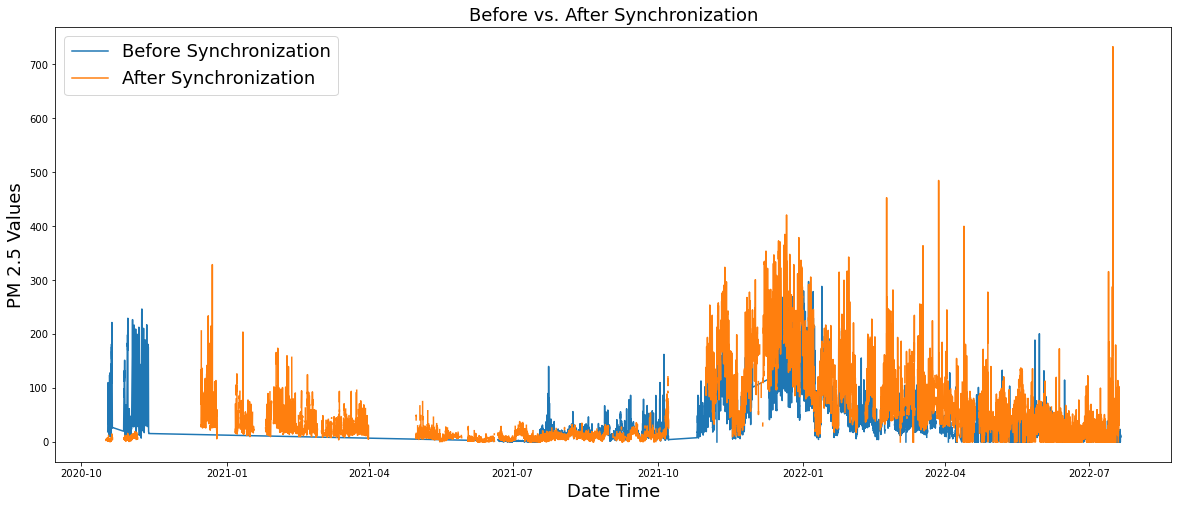

In [8]:
sensor_i = Aqm_Pune[Aqm_Pune['id'] == dum[1]]             # Extract i'th sensor data from raw data
plt.figure(figsize=(20,8))
plt.plot(sensor_i['observationDateTime'][:], sensor_i['pm2p5.avgOverTime'][:].values, label = 'Before Synchronization')
plt.plot(dummydf_pm2p5.timestamp, time_series_data_pm2p5[0], label = 'After Synchronization')
plt.legend(fontsize=18)
plt.title("Before vs. After Synchronization",fontsize=18)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('PM 2.5 Values',fontsize=18)

Text(0, 0.5, 'PM 2.5 Values')

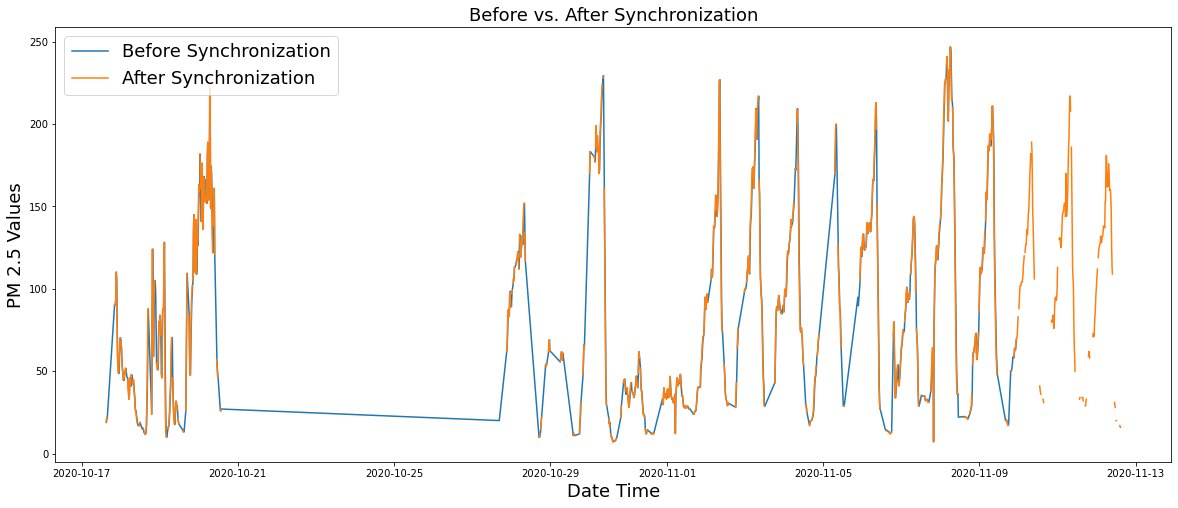

In [12]:
plt.figure(figsize=(20,8))
#plt.plot(time_series_data_pm2p5[1])
plt.plot(sensor_i['observationDateTime'][:1000], sensor_i['pm2p5.avgOverTime'][:1000].values, label = 'Before Synchronization')
plt.plot(dummydf_pm2p5['timestamp'][:10000], time_series_data_pm2p5[1][:10000], label = 'After Synchronization')
plt.legend(fontsize=18)
plt.title("Before vs. After Synchronization",fontsize=18)
plt.xlabel('Date Time',fontsize=18)
plt.ylabel('PM 2.5 Values',fontsize=18)